In [1]:
# Imports
import numpy as np
import pandas as pd
import os
from utilities import *
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import gc
import itertools
%matplotlib inline

gc.enable()

train = pd.read_csv('training_set.csv')
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']
train_det = train.where(train['detected'] == 1)

aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

aggs_det = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['mean', 'std', 'var'],
}

agg_train = train.groupby('object_id').agg(aggs)
agg_train_det = train_det.groupby('object_id').agg(aggs_det)

new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
new_columns_det = [
    k + '_' + agg for k in aggs_det.keys() for agg in aggs_det[k]
]

agg_train.columns = new_columns
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

agg_train_det.columns = new_columns_det
agg_train_det['mjd_diff'] = agg_train_det['mjd_max'] - agg_train_det['mjd_min']

agg_train_det.columns = agg_train_det.columns + "_det"

del agg_train_det['mjd_max_det'], agg_train_det['mjd_min_det']

agg_train = pd.concat([agg_train, agg_train_det], axis=1, join='inner')

del train, train_det, agg_train_det
gc.collect()

agg_train = agg_train.values

In [2]:
X_feats = pd.read_csv('training_set_metadata_head.csv')
X_feats = X_feats.iloc[:,np.array([7, 8, 9, 10])]
X_feats['distmod'].fillna(0, inplace=True)
X_feats = X_feats.values

X_period = pd.read_csv('F:\\Documents\\Kaggle\\Results2\\lc_period.csv', header=None).values
X_power = pd.read_csv('F:\\Documents\\Kaggle\\Results2\\lc_power.csv', header=None).values
X_range = pd.read_csv('F:\\Documents\\Kaggle\\Results2\\lc_range.csv', header=None).values
X_skew = pd.read_csv('F:\\Documents\\Kaggle\\Results2\\lc_skewness.csv', header=None).values

X_feats = np.concatenate((X_feats, X_period, X_power, X_range, X_skew, agg_train), axis = 1)

X_all, labels_all = read_data_all2(data_path="F:\\Documents\\Kaggle\\PLAsTiCC")
X_all_p, labels_all_p = read_data_all2_p(data_path="F:\\Documents\\Kaggle\\PLAsTiCC")

  0%|                                                    | 0/6 [00:00<?, ?it/s]F:\Documents\Kaggle\PLAsTiCC\utilities.py:222: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X[:,:,i_ch] = dat_.as_matrix()
  0%|                                                    | 0/6 [00:00<?, ?it/s]F:\Documents\Kaggle\PLAsTiCC\utilities.py:266: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X[:,:,i_ch] = dat_.as_matrix()
100%|████████████████████████████████████████████| 6/6 [00:14<00:00,  2.49s/it]


In [3]:
# Normalize?
X_all[:,1:1999,:] = standardize_full(X_all[:,1:1999,:])
X_all_p = standardize_full(X_all_p)
X_feats = standardize_feats_full(X_feats)

In [4]:
X_train, X_test, labels_train, labels_test = train_test_split(X_all, labels_all,
                                                stratify = labels_all, random_state = 111, test_size = 0.2)

X_train_feats, X_test_feats, _ , _ = train_test_split(X_feats, labels_all,
                                                stratify = labels_all, random_state = 111, test_size = 0.2)

X_train_p, X_test_p, _ , _ = train_test_split(X_all_p, labels_all,
                                                stratify = labels_all, random_state = 111, test_size = 0.2)

X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 222, test_size = 0.2)

X_tr_f, X_vld_f, lab_tr_f, lab_vld_f = train_test_split(X_train_feats, labels_train, 
                                                stratify = labels_train, random_state = 222, test_size = 0.2)

X_tr_p, X_vld_p, lab_tr_p, lab_vld_p = train_test_split(X_train_p, labels_train, 
                                                stratify = labels_train, random_state = 222, test_size = 0.2)

X_tr_f

array([[-0.65604672, -0.51838063, -1.53349927, ...,  1.43768042,
         1.60602404,  1.3282128 ],
       [-0.65604672, -0.51838063, -1.53349927, ...,  0.17531013,
        -0.01337359, -0.62363898],
       [-0.65604672, -0.51838063, -1.53349927, ..., -0.02197492,
        -0.21165453,  1.61488196],
       ...,
       [ 4.07982946,  3.38275786,  0.92914195, ...,  0.67226942,
         0.55175057, -0.66359923],
       [ 0.30872651, -0.03760535,  0.7052746 , ...,  0.37909655,
         0.20699545, -0.71820108],
       [-0.65604672, -0.51838063, -1.53349927, ...,  1.00470792,
         0.98225836,  1.73802519]])

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

X_tr_f

array([[-0.65604672, -0.51838063, -1.53349927, ...,  1.43768042,
         1.60602404,  1.3282128 ],
       [-0.65604672, -0.51838063, -1.53349927, ...,  0.17531013,
        -0.01337359, -0.62363898],
       [-0.65604672, -0.51838063, -1.53349927, ..., -0.02197492,
        -0.21165453,  1.61488196],
       ...,
       [ 4.07982946,  3.38275786,  0.92914195, ...,  0.67226942,
         0.55175057, -0.66359923],
       [ 0.30872651, -0.03760535,  0.7052746 , ...,  0.37909655,
         0.20699545, -0.71820108],
       [-0.65604672, -0.51838063, -1.53349927, ...,  1.00470792,
         0.98225836,  1.73802519]])

In [6]:
# Imports
import tensorflow as tf

C:\Users\Ross\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
batch_size = 50       # Batch size
seq_len = 2000          # Number of steps
learning_rate = 0.0001
epochs = 100

n_classes = 14
n_channels = 6

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    inputs2_ = tf.placeholder(tf.float32, [None, 34], name = 'inputs2')
    inputs3_ = tf.placeholder(tf.float32, [None, seq_len/2, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

In [9]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=20, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=32, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=16, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=64, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=12, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=64, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=8, strides=2, padding='same')
    
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1_p = tf.layers.conv1d(inputs=inputs3_, filters=32, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1_p = tf.layers.max_pooling1d(inputs=conv1_p, pool_size=10, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2_p = tf.layers.conv1d(inputs=max_pool_1_p, filters=32, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2_p = tf.layers.max_pooling1d(inputs=conv2_p, pool_size=8, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3_p = tf.layers.conv1d(inputs=max_pool_2_p, filters=64, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3_p = tf.layers.max_pooling1d(inputs=conv3_p, pool_size=6, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4_p = tf.layers.conv1d(inputs=max_pool_3_p, filters=64, kernel_size=10, strides=2, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4_p = tf.layers.max_pooling1d(inputs=conv4_p, pool_size=4, strides=2, padding='same')
    
print(max_pool_4.get_shape().as_list())
print(max_pool_4_p.get_shape().as_list())

[None, 8, 64]
[None, 4, 64]


In [10]:
with graph.as_default():
    # Flatten and add dropout
    nnfeats = tf.layers.dense(inputs=inputs2_, units=512, activation=tf.nn.tanh)
    nnfeats2 = tf.nn.dropout(nnfeats, keep_prob=keep_prob_)
    nnfeats3 = tf.layers.dense(inputs=nnfeats2, units=256, activation=tf.nn.tanh)
    nnfeats4 = tf.nn.dropout(nnfeats3, keep_prob=keep_prob_)
    nnfeats5 = tf.layers.dense(inputs=nnfeats4, units=128, activation=tf.nn.tanh)
    nnfeats6 = tf.nn.dropout(nnfeats5, keep_prob=keep_prob_)
    nnfeats7 = tf.layers.dense(inputs=nnfeats6, units=64, activation=tf.nn.tanh)
    nnfeats8 = tf.nn.dropout(nnfeats7, keep_prob=keep_prob_)
    
    flat = tf.concat([tf.reshape(max_pool_4, (-1, 8*64)), nnfeats8, tf.reshape(max_pool_4_p, (-1, 4*64))], 1)
    flat2 = tf.nn.dropout(flat, keep_prob=keep_prob_)
    flat3 = tf.layers.dense(inputs=flat2, units=512, activation=tf.nn.tanh)
    flat4 = tf.nn.dropout(flat3, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat4, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    
print(flat.get_shape().as_list())

[None, 832]


In [11]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [12]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()
    
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(graph=graph, config=config) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y,x_f,x_p in get_batches(X_tr, y_tr, X_tr_f, X_tr_p, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, inputs2_ : x_f, inputs3_ : x_p, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v, x_v_f, x_v_p in get_batches(X_vld, y_vld, X_vld_f, X_vld_p, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, inputs2_ : x_v_f, inputs3_ : x_v_p, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/100 Iteration: 5 Train loss: 2.818925 Train acc: 0.100000
Epoch: 0/100 Iteration: 10 Train loss: 2.616758 Train acc: 0.140000
Epoch: 0/100 Iteration: 10 Validation loss: 2.503188 Validation acc: 0.251200
Epoch: 0/100 Iteration: 15 Train loss: 2.783561 Train acc: 0.080000
Epoch: 0/100 Iteration: 20 Train loss: 2.625853 Train acc: 0.120000
Epoch: 0/100 Iteration: 20 Validation loss: 2.426925 Validation acc: 0.390400
Epoch: 0/100 Iteration: 25 Train loss: 2.682327 Train acc: 0.120000
Epoch: 0/100 Iteration: 30 Train loss: 2.664144 Train acc: 0.080000
Epoch: 0/100 Iteration: 30 Validation loss: 2.355314 Validation acc: 0.440000
Epoch: 0/100 Iteration: 35 Train loss: 2.620240 Train acc: 0.200000
Epoch: 0/100 Iteration: 40 Train loss: 2.639557 Train acc: 0.080000
Epoch: 0/100 Iteration: 40 Validation loss: 2.277789 Validation acc: 0.491200
Epoch: 0/100 Iteration: 45 Train loss: 2.418888 Train acc: 0.220000
Epoch: 0/100 Iteration: 50 Train loss: 2.476978 Train acc: 0.200000
Epoch: 0/

Epoch: 3/100 Iteration: 380 Validation loss: 1.226693 Validation acc: 0.592000
Epoch: 3/100 Iteration: 385 Train loss: 1.657018 Train acc: 0.460000
Epoch: 3/100 Iteration: 390 Train loss: 1.542406 Train acc: 0.460000
Epoch: 3/100 Iteration: 390 Validation loss: 1.201402 Validation acc: 0.596000
Epoch: 3/100 Iteration: 395 Train loss: 1.506150 Train acc: 0.440000
Epoch: 3/100 Iteration: 400 Train loss: 1.417389 Train acc: 0.580000
Epoch: 3/100 Iteration: 400 Validation loss: 1.189927 Validation acc: 0.598400
Epoch: 4/100 Iteration: 405 Train loss: 1.380864 Train acc: 0.620000
Epoch: 4/100 Iteration: 410 Train loss: 1.666826 Train acc: 0.440000
Epoch: 4/100 Iteration: 410 Validation loss: 1.194549 Validation acc: 0.597600
Epoch: 4/100 Iteration: 415 Train loss: 1.399408 Train acc: 0.480000
Epoch: 4/100 Iteration: 420 Train loss: 1.133848 Train acc: 0.600000
Epoch: 4/100 Iteration: 420 Validation loss: 1.187829 Validation acc: 0.603200
Epoch: 4/100 Iteration: 425 Train loss: 1.474109 Trai

Epoch: 7/100 Iteration: 760 Train loss: 0.932871 Train acc: 0.700000
Epoch: 7/100 Iteration: 760 Validation loss: 1.073718 Validation acc: 0.616000
Epoch: 7/100 Iteration: 765 Train loss: 1.143597 Train acc: 0.580000
Epoch: 7/100 Iteration: 770 Train loss: 1.279315 Train acc: 0.560000
Epoch: 7/100 Iteration: 770 Validation loss: 1.066198 Validation acc: 0.617600
Epoch: 7/100 Iteration: 775 Train loss: 1.178345 Train acc: 0.640000
Epoch: 7/100 Iteration: 780 Train loss: 1.381885 Train acc: 0.520000
Epoch: 7/100 Iteration: 780 Validation loss: 1.075513 Validation acc: 0.618400
Epoch: 7/100 Iteration: 785 Train loss: 1.292921 Train acc: 0.600000
Epoch: 7/100 Iteration: 790 Train loss: 1.387664 Train acc: 0.560000
Epoch: 7/100 Iteration: 790 Validation loss: 1.060525 Validation acc: 0.617600
Epoch: 7/100 Iteration: 795 Train loss: 1.287736 Train acc: 0.580000
Epoch: 7/100 Iteration: 800 Train loss: 1.276741 Train acc: 0.540000
Epoch: 7/100 Iteration: 800 Validation loss: 1.062877 Validatio

Epoch: 11/100 Iteration: 1130 Validation loss: 1.013455 Validation acc: 0.636000
Epoch: 11/100 Iteration: 1135 Train loss: 1.136867 Train acc: 0.640000
Epoch: 11/100 Iteration: 1140 Train loss: 1.213556 Train acc: 0.580000
Epoch: 11/100 Iteration: 1140 Validation loss: 1.018658 Validation acc: 0.634400
Epoch: 11/100 Iteration: 1145 Train loss: 0.932693 Train acc: 0.700000
Epoch: 11/100 Iteration: 1150 Train loss: 1.294211 Train acc: 0.600000
Epoch: 11/100 Iteration: 1150 Validation loss: 1.012634 Validation acc: 0.636000
Epoch: 11/100 Iteration: 1155 Train loss: 1.078815 Train acc: 0.700000
Epoch: 11/100 Iteration: 1160 Train loss: 0.984634 Train acc: 0.700000
Epoch: 11/100 Iteration: 1160 Validation loss: 1.006191 Validation acc: 0.633600
Epoch: 11/100 Iteration: 1165 Train loss: 0.989153 Train acc: 0.640000
Epoch: 11/100 Iteration: 1170 Train loss: 0.950049 Train acc: 0.680000
Epoch: 11/100 Iteration: 1170 Validation loss: 0.999360 Validation acc: 0.636800
Epoch: 11/100 Iteration: 11

Epoch: 14/100 Iteration: 1500 Train loss: 1.169436 Train acc: 0.600000
Epoch: 14/100 Iteration: 1500 Validation loss: 0.962504 Validation acc: 0.662400
Epoch: 15/100 Iteration: 1505 Train loss: 1.173731 Train acc: 0.640000
Epoch: 15/100 Iteration: 1510 Train loss: 1.193963 Train acc: 0.540000
Epoch: 15/100 Iteration: 1510 Validation loss: 0.978767 Validation acc: 0.653600
Epoch: 15/100 Iteration: 1515 Train loss: 1.187320 Train acc: 0.640000
Epoch: 15/100 Iteration: 1520 Train loss: 0.876998 Train acc: 0.720000
Epoch: 15/100 Iteration: 1520 Validation loss: 0.962806 Validation acc: 0.665600
Epoch: 15/100 Iteration: 1525 Train loss: 1.065316 Train acc: 0.640000
Epoch: 15/100 Iteration: 1530 Train loss: 0.900224 Train acc: 0.720000
Epoch: 15/100 Iteration: 1530 Validation loss: 0.969825 Validation acc: 0.656000
Epoch: 15/100 Iteration: 1535 Train loss: 1.092257 Train acc: 0.700000
Epoch: 15/100 Iteration: 1540 Train loss: 1.252778 Train acc: 0.560000
Epoch: 15/100 Iteration: 1540 Validat

Epoch: 18/100 Iteration: 1865 Train loss: 0.814828 Train acc: 0.700000
Epoch: 18/100 Iteration: 1870 Train loss: 0.931506 Train acc: 0.660000
Epoch: 18/100 Iteration: 1870 Validation loss: 0.939987 Validation acc: 0.669600
Epoch: 18/100 Iteration: 1875 Train loss: 1.120168 Train acc: 0.640000
Epoch: 18/100 Iteration: 1880 Train loss: 1.139509 Train acc: 0.640000
Epoch: 18/100 Iteration: 1880 Validation loss: 0.943675 Validation acc: 0.670400
Epoch: 18/100 Iteration: 1885 Train loss: 1.000964 Train acc: 0.600000
Epoch: 18/100 Iteration: 1890 Train loss: 1.360398 Train acc: 0.560000
Epoch: 18/100 Iteration: 1890 Validation loss: 0.916430 Validation acc: 0.684800
Epoch: 18/100 Iteration: 1895 Train loss: 0.840018 Train acc: 0.740000
Epoch: 18/100 Iteration: 1900 Train loss: 0.947874 Train acc: 0.720000
Epoch: 18/100 Iteration: 1900 Validation loss: 0.927448 Validation acc: 0.676800
Epoch: 19/100 Iteration: 1905 Train loss: 1.192223 Train acc: 0.580000
Epoch: 19/100 Iteration: 1910 Train l

Epoch: 22/100 Iteration: 2230 Validation loss: 0.907673 Validation acc: 0.684800
Epoch: 22/100 Iteration: 2235 Train loss: 1.051954 Train acc: 0.640000
Epoch: 22/100 Iteration: 2240 Train loss: 1.145697 Train acc: 0.580000
Epoch: 22/100 Iteration: 2240 Validation loss: 0.910900 Validation acc: 0.678400
Epoch: 22/100 Iteration: 2245 Train loss: 0.848458 Train acc: 0.780000
Epoch: 22/100 Iteration: 2250 Train loss: 1.183667 Train acc: 0.580000
Epoch: 22/100 Iteration: 2250 Validation loss: 0.903299 Validation acc: 0.687200
Epoch: 22/100 Iteration: 2255 Train loss: 0.846576 Train acc: 0.760000
Epoch: 22/100 Iteration: 2260 Train loss: 0.854857 Train acc: 0.700000
Epoch: 22/100 Iteration: 2260 Validation loss: 0.906827 Validation acc: 0.690400
Epoch: 22/100 Iteration: 2265 Train loss: 0.673437 Train acc: 0.800000
Epoch: 22/100 Iteration: 2270 Train loss: 0.902086 Train acc: 0.760000
Epoch: 22/100 Iteration: 2270 Validation loss: 0.899367 Validation acc: 0.696000
Epoch: 22/100 Iteration: 22

Epoch: 25/100 Iteration: 2600 Train loss: 0.977105 Train acc: 0.680000
Epoch: 25/100 Iteration: 2600 Validation loss: 0.893680 Validation acc: 0.702400
Epoch: 26/100 Iteration: 2605 Train loss: 1.226100 Train acc: 0.620000
Epoch: 26/100 Iteration: 2610 Train loss: 0.914602 Train acc: 0.600000
Epoch: 26/100 Iteration: 2610 Validation loss: 0.890441 Validation acc: 0.700000
Epoch: 26/100 Iteration: 2615 Train loss: 1.164858 Train acc: 0.600000
Epoch: 26/100 Iteration: 2620 Train loss: 0.775385 Train acc: 0.740000
Epoch: 26/100 Iteration: 2620 Validation loss: 0.879172 Validation acc: 0.708000
Epoch: 26/100 Iteration: 2625 Train loss: 0.753691 Train acc: 0.740000
Epoch: 26/100 Iteration: 2630 Train loss: 0.990614 Train acc: 0.700000
Epoch: 26/100 Iteration: 2630 Validation loss: 0.886798 Validation acc: 0.706400
Epoch: 26/100 Iteration: 2635 Train loss: 1.147161 Train acc: 0.600000
Epoch: 26/100 Iteration: 2640 Train loss: 0.973925 Train acc: 0.740000
Epoch: 26/100 Iteration: 2640 Validat

Epoch: 29/100 Iteration: 2965 Train loss: 0.705398 Train acc: 0.800000
Epoch: 29/100 Iteration: 2970 Train loss: 0.650896 Train acc: 0.780000
Epoch: 29/100 Iteration: 2970 Validation loss: 0.861595 Validation acc: 0.711200
Epoch: 29/100 Iteration: 2975 Train loss: 1.043134 Train acc: 0.700000
Epoch: 29/100 Iteration: 2980 Train loss: 0.977053 Train acc: 0.640000
Epoch: 29/100 Iteration: 2980 Validation loss: 0.861578 Validation acc: 0.710400
Epoch: 29/100 Iteration: 2985 Train loss: 0.815072 Train acc: 0.740000
Epoch: 29/100 Iteration: 2990 Train loss: 0.953141 Train acc: 0.580000
Epoch: 29/100 Iteration: 2990 Validation loss: 0.846898 Validation acc: 0.716800
Epoch: 29/100 Iteration: 2995 Train loss: 0.757063 Train acc: 0.680000
Epoch: 29/100 Iteration: 3000 Train loss: 0.938110 Train acc: 0.720000
Epoch: 29/100 Iteration: 3000 Validation loss: 0.865958 Validation acc: 0.715200
Epoch: 30/100 Iteration: 3005 Train loss: 0.994905 Train acc: 0.700000
Epoch: 30/100 Iteration: 3010 Train l

Epoch: 33/100 Iteration: 3330 Validation loss: 0.846790 Validation acc: 0.714400
Epoch: 33/100 Iteration: 3335 Train loss: 0.852768 Train acc: 0.740000
Epoch: 33/100 Iteration: 3340 Train loss: 1.036346 Train acc: 0.680000
Epoch: 33/100 Iteration: 3340 Validation loss: 0.842481 Validation acc: 0.715200
Epoch: 33/100 Iteration: 3345 Train loss: 0.735587 Train acc: 0.720000
Epoch: 33/100 Iteration: 3350 Train loss: 1.014318 Train acc: 0.660000
Epoch: 33/100 Iteration: 3350 Validation loss: 0.833103 Validation acc: 0.716800
Epoch: 33/100 Iteration: 3355 Train loss: 0.746979 Train acc: 0.800000
Epoch: 33/100 Iteration: 3360 Train loss: 0.796290 Train acc: 0.720000
Epoch: 33/100 Iteration: 3360 Validation loss: 0.849654 Validation acc: 0.715200
Epoch: 33/100 Iteration: 3365 Train loss: 0.691245 Train acc: 0.760000
Epoch: 33/100 Iteration: 3370 Train loss: 0.719818 Train acc: 0.740000
Epoch: 33/100 Iteration: 3370 Validation loss: 0.852155 Validation acc: 0.714400
Epoch: 33/100 Iteration: 33

Epoch: 36/100 Iteration: 3700 Train loss: 0.927963 Train acc: 0.700000
Epoch: 36/100 Iteration: 3700 Validation loss: 0.837555 Validation acc: 0.725600
Epoch: 37/100 Iteration: 3705 Train loss: 1.085934 Train acc: 0.580000
Epoch: 37/100 Iteration: 3710 Train loss: 1.062279 Train acc: 0.640000
Epoch: 37/100 Iteration: 3710 Validation loss: 0.830199 Validation acc: 0.729600
Epoch: 37/100 Iteration: 3715 Train loss: 0.915140 Train acc: 0.640000
Epoch: 37/100 Iteration: 3720 Train loss: 0.626469 Train acc: 0.820000
Epoch: 37/100 Iteration: 3720 Validation loss: 0.819453 Validation acc: 0.728000
Epoch: 37/100 Iteration: 3725 Train loss: 0.701994 Train acc: 0.800000
Epoch: 37/100 Iteration: 3730 Train loss: 0.789654 Train acc: 0.740000
Epoch: 37/100 Iteration: 3730 Validation loss: 0.847133 Validation acc: 0.715200
Epoch: 37/100 Iteration: 3735 Train loss: 0.900804 Train acc: 0.740000
Epoch: 37/100 Iteration: 3740 Train loss: 0.966223 Train acc: 0.760000
Epoch: 37/100 Iteration: 3740 Validat

Epoch: 40/100 Iteration: 4065 Train loss: 0.625321 Train acc: 0.780000
Epoch: 40/100 Iteration: 4070 Train loss: 0.703690 Train acc: 0.720000
Epoch: 40/100 Iteration: 4070 Validation loss: 0.820473 Validation acc: 0.728000
Epoch: 40/100 Iteration: 4075 Train loss: 0.791506 Train acc: 0.740000
Epoch: 40/100 Iteration: 4080 Train loss: 0.912811 Train acc: 0.680000
Epoch: 40/100 Iteration: 4080 Validation loss: 0.814102 Validation acc: 0.731200
Epoch: 40/100 Iteration: 4085 Train loss: 0.756491 Train acc: 0.720000
Epoch: 40/100 Iteration: 4090 Train loss: 0.837999 Train acc: 0.680000
Epoch: 40/100 Iteration: 4090 Validation loss: 0.802837 Validation acc: 0.728800
Epoch: 40/100 Iteration: 4095 Train loss: 0.704677 Train acc: 0.780000
Epoch: 40/100 Iteration: 4100 Train loss: 0.872533 Train acc: 0.760000
Epoch: 40/100 Iteration: 4100 Validation loss: 0.833557 Validation acc: 0.729600
Epoch: 41/100 Iteration: 4105 Train loss: 0.810897 Train acc: 0.680000
Epoch: 41/100 Iteration: 4110 Train l

Epoch: 44/100 Iteration: 4430 Validation loss: 0.799840 Validation acc: 0.733600
Epoch: 44/100 Iteration: 4435 Train loss: 0.807435 Train acc: 0.780000
Epoch: 44/100 Iteration: 4440 Train loss: 0.885948 Train acc: 0.740000
Epoch: 44/100 Iteration: 4440 Validation loss: 0.811806 Validation acc: 0.732800
Epoch: 44/100 Iteration: 4445 Train loss: 0.670005 Train acc: 0.780000
Epoch: 44/100 Iteration: 4450 Train loss: 0.880948 Train acc: 0.720000
Epoch: 44/100 Iteration: 4450 Validation loss: 0.803976 Validation acc: 0.733600
Epoch: 44/100 Iteration: 4455 Train loss: 0.664914 Train acc: 0.760000
Epoch: 44/100 Iteration: 4460 Train loss: 0.837749 Train acc: 0.760000
Epoch: 44/100 Iteration: 4460 Validation loss: 0.816694 Validation acc: 0.725600
Epoch: 44/100 Iteration: 4465 Train loss: 0.613026 Train acc: 0.800000
Epoch: 44/100 Iteration: 4470 Train loss: 0.680894 Train acc: 0.740000
Epoch: 44/100 Iteration: 4470 Validation loss: 0.828701 Validation acc: 0.727200
Epoch: 44/100 Iteration: 44

Epoch: 47/100 Iteration: 4800 Train loss: 0.717506 Train acc: 0.760000
Epoch: 47/100 Iteration: 4800 Validation loss: 0.819815 Validation acc: 0.729600
Epoch: 48/100 Iteration: 4805 Train loss: 0.975385 Train acc: 0.660000
Epoch: 48/100 Iteration: 4810 Train loss: 0.720039 Train acc: 0.740000
Epoch: 48/100 Iteration: 4810 Validation loss: 0.804026 Validation acc: 0.732800
Epoch: 48/100 Iteration: 4815 Train loss: 0.750007 Train acc: 0.700000
Epoch: 48/100 Iteration: 4820 Train loss: 0.545502 Train acc: 0.820000
Epoch: 48/100 Iteration: 4820 Validation loss: 0.788369 Validation acc: 0.736000
Epoch: 48/100 Iteration: 4825 Train loss: 0.669569 Train acc: 0.740000
Epoch: 48/100 Iteration: 4830 Train loss: 0.766847 Train acc: 0.760000
Epoch: 48/100 Iteration: 4830 Validation loss: 0.790633 Validation acc: 0.738400
Epoch: 48/100 Iteration: 4835 Train loss: 0.842874 Train acc: 0.720000
Epoch: 48/100 Iteration: 4840 Train loss: 0.951768 Train acc: 0.720000
Epoch: 48/100 Iteration: 4840 Validat

Epoch: 51/100 Iteration: 5165 Train loss: 0.522347 Train acc: 0.840000
Epoch: 51/100 Iteration: 5170 Train loss: 0.588897 Train acc: 0.800000
Epoch: 51/100 Iteration: 5170 Validation loss: 0.780238 Validation acc: 0.740800
Epoch: 51/100 Iteration: 5175 Train loss: 0.798540 Train acc: 0.700000
Epoch: 51/100 Iteration: 5180 Train loss: 0.880099 Train acc: 0.660000
Epoch: 51/100 Iteration: 5180 Validation loss: 0.790145 Validation acc: 0.744800
Epoch: 51/100 Iteration: 5185 Train loss: 0.722833 Train acc: 0.760000
Epoch: 51/100 Iteration: 5190 Train loss: 0.775153 Train acc: 0.740000
Epoch: 51/100 Iteration: 5190 Validation loss: 0.773030 Validation acc: 0.743200
Epoch: 51/100 Iteration: 5195 Train loss: 0.729223 Train acc: 0.760000
Epoch: 51/100 Iteration: 5200 Train loss: 0.768930 Train acc: 0.760000
Epoch: 51/100 Iteration: 5200 Validation loss: 0.802290 Validation acc: 0.740000
Epoch: 52/100 Iteration: 5205 Train loss: 0.963617 Train acc: 0.680000
Epoch: 52/100 Iteration: 5210 Train l

Epoch: 55/100 Iteration: 5530 Validation loss: 0.774337 Validation acc: 0.743200
Epoch: 55/100 Iteration: 5535 Train loss: 0.936385 Train acc: 0.740000
Epoch: 55/100 Iteration: 5540 Train loss: 0.885593 Train acc: 0.740000
Epoch: 55/100 Iteration: 5540 Validation loss: 0.766231 Validation acc: 0.744000
Epoch: 55/100 Iteration: 5545 Train loss: 0.635810 Train acc: 0.740000
Epoch: 55/100 Iteration: 5550 Train loss: 0.815452 Train acc: 0.660000
Epoch: 55/100 Iteration: 5550 Validation loss: 0.763143 Validation acc: 0.745600
Epoch: 55/100 Iteration: 5555 Train loss: 0.604777 Train acc: 0.780000
Epoch: 55/100 Iteration: 5560 Train loss: 0.708706 Train acc: 0.720000
Epoch: 55/100 Iteration: 5560 Validation loss: 0.782478 Validation acc: 0.741600
Epoch: 55/100 Iteration: 5565 Train loss: 0.525963 Train acc: 0.820000
Epoch: 55/100 Iteration: 5570 Train loss: 0.617928 Train acc: 0.780000
Epoch: 55/100 Iteration: 5570 Validation loss: 0.774312 Validation acc: 0.741600
Epoch: 55/100 Iteration: 55

Epoch: 58/100 Iteration: 5900 Train loss: 0.798858 Train acc: 0.740000
Epoch: 58/100 Iteration: 5900 Validation loss: 0.777581 Validation acc: 0.743200
Epoch: 59/100 Iteration: 5905 Train loss: 0.828796 Train acc: 0.700000
Epoch: 59/100 Iteration: 5910 Train loss: 0.867585 Train acc: 0.700000
Epoch: 59/100 Iteration: 5910 Validation loss: 0.776445 Validation acc: 0.743200
Epoch: 59/100 Iteration: 5915 Train loss: 0.720967 Train acc: 0.660000
Epoch: 59/100 Iteration: 5920 Train loss: 0.449879 Train acc: 0.840000
Epoch: 59/100 Iteration: 5920 Validation loss: 0.749532 Validation acc: 0.748800
Epoch: 59/100 Iteration: 5925 Train loss: 0.650636 Train acc: 0.800000
Epoch: 59/100 Iteration: 5930 Train loss: 0.598847 Train acc: 0.760000
Epoch: 59/100 Iteration: 5930 Validation loss: 0.751800 Validation acc: 0.744800
Epoch: 59/100 Iteration: 5935 Train loss: 0.857460 Train acc: 0.740000
Epoch: 59/100 Iteration: 5940 Train loss: 0.904078 Train acc: 0.720000
Epoch: 59/100 Iteration: 5940 Validat

Epoch: 62/100 Iteration: 6265 Train loss: 0.536495 Train acc: 0.820000
Epoch: 62/100 Iteration: 6270 Train loss: 0.534228 Train acc: 0.840000
Epoch: 62/100 Iteration: 6270 Validation loss: 0.782163 Validation acc: 0.741600
Epoch: 62/100 Iteration: 6275 Train loss: 0.614718 Train acc: 0.780000
Epoch: 62/100 Iteration: 6280 Train loss: 0.757777 Train acc: 0.740000
Epoch: 62/100 Iteration: 6280 Validation loss: 0.755174 Validation acc: 0.743200
Epoch: 62/100 Iteration: 6285 Train loss: 0.883192 Train acc: 0.680000
Epoch: 62/100 Iteration: 6290 Train loss: 0.791980 Train acc: 0.700000
Epoch: 62/100 Iteration: 6290 Validation loss: 0.755258 Validation acc: 0.751200
Epoch: 62/100 Iteration: 6295 Train loss: 0.606238 Train acc: 0.800000
Epoch: 62/100 Iteration: 6300 Train loss: 0.650548 Train acc: 0.740000
Epoch: 62/100 Iteration: 6300 Validation loss: 0.789714 Validation acc: 0.745600
Epoch: 63/100 Iteration: 6305 Train loss: 0.848301 Train acc: 0.720000
Epoch: 63/100 Iteration: 6310 Train l

Epoch: 66/100 Iteration: 6630 Validation loss: 0.743911 Validation acc: 0.744000
Epoch: 66/100 Iteration: 6635 Train loss: 0.891792 Train acc: 0.720000
Epoch: 66/100 Iteration: 6640 Train loss: 0.897590 Train acc: 0.700000
Epoch: 66/100 Iteration: 6640 Validation loss: 0.746599 Validation acc: 0.745600
Epoch: 66/100 Iteration: 6645 Train loss: 0.697541 Train acc: 0.780000
Epoch: 66/100 Iteration: 6650 Train loss: 0.642936 Train acc: 0.760000
Epoch: 66/100 Iteration: 6650 Validation loss: 0.746093 Validation acc: 0.753600
Epoch: 66/100 Iteration: 6655 Train loss: 0.635441 Train acc: 0.740000
Epoch: 66/100 Iteration: 6660 Train loss: 0.639956 Train acc: 0.800000
Epoch: 66/100 Iteration: 6660 Validation loss: 0.759777 Validation acc: 0.750400
Epoch: 66/100 Iteration: 6665 Train loss: 0.573940 Train acc: 0.800000
Epoch: 66/100 Iteration: 6670 Train loss: 0.540043 Train acc: 0.800000
Epoch: 66/100 Iteration: 6670 Validation loss: 0.763431 Validation acc: 0.748000
Epoch: 66/100 Iteration: 66

Epoch: 69/100 Iteration: 7000 Train loss: 0.632751 Train acc: 0.740000
Epoch: 69/100 Iteration: 7000 Validation loss: 0.791211 Validation acc: 0.743200
Epoch: 70/100 Iteration: 7005 Train loss: 0.954967 Train acc: 0.680000
Epoch: 70/100 Iteration: 7010 Train loss: 0.729499 Train acc: 0.760000
Epoch: 70/100 Iteration: 7010 Validation loss: 0.782204 Validation acc: 0.741600
Epoch: 70/100 Iteration: 7015 Train loss: 0.598719 Train acc: 0.740000
Epoch: 70/100 Iteration: 7020 Train loss: 0.392716 Train acc: 0.880000
Epoch: 70/100 Iteration: 7020 Validation loss: 0.751650 Validation acc: 0.756800
Epoch: 70/100 Iteration: 7025 Train loss: 0.474229 Train acc: 0.800000
Epoch: 70/100 Iteration: 7030 Train loss: 0.674853 Train acc: 0.780000
Epoch: 70/100 Iteration: 7030 Validation loss: 0.749628 Validation acc: 0.752000
Epoch: 70/100 Iteration: 7035 Train loss: 0.744904 Train acc: 0.760000
Epoch: 70/100 Iteration: 7040 Train loss: 0.839354 Train acc: 0.740000
Epoch: 70/100 Iteration: 7040 Validat

Epoch: 73/100 Iteration: 7365 Train loss: 0.480729 Train acc: 0.860000
Epoch: 73/100 Iteration: 7370 Train loss: 0.552141 Train acc: 0.780000
Epoch: 73/100 Iteration: 7370 Validation loss: 0.792541 Validation acc: 0.750400
Epoch: 73/100 Iteration: 7375 Train loss: 0.638419 Train acc: 0.780000
Epoch: 73/100 Iteration: 7380 Train loss: 0.710663 Train acc: 0.760000
Epoch: 73/100 Iteration: 7380 Validation loss: 0.743510 Validation acc: 0.762400
Epoch: 73/100 Iteration: 7385 Train loss: 0.698294 Train acc: 0.720000
Epoch: 73/100 Iteration: 7390 Train loss: 0.686183 Train acc: 0.740000
Epoch: 73/100 Iteration: 7390 Validation loss: 0.749447 Validation acc: 0.769600
Epoch: 73/100 Iteration: 7395 Train loss: 0.638085 Train acc: 0.760000
Epoch: 73/100 Iteration: 7400 Train loss: 0.683383 Train acc: 0.760000
Epoch: 73/100 Iteration: 7400 Validation loss: 0.784176 Validation acc: 0.755200
Epoch: 74/100 Iteration: 7405 Train loss: 0.824334 Train acc: 0.660000
Epoch: 74/100 Iteration: 7410 Train l

Epoch: 77/100 Iteration: 7730 Validation loss: 0.733118 Validation acc: 0.757600
Epoch: 77/100 Iteration: 7735 Train loss: 0.799689 Train acc: 0.740000
Epoch: 77/100 Iteration: 7740 Train loss: 0.870423 Train acc: 0.760000
Epoch: 77/100 Iteration: 7740 Validation loss: 0.739340 Validation acc: 0.751200
Epoch: 77/100 Iteration: 7745 Train loss: 0.669633 Train acc: 0.840000
Epoch: 77/100 Iteration: 7750 Train loss: 0.739839 Train acc: 0.740000
Epoch: 77/100 Iteration: 7750 Validation loss: 0.737271 Validation acc: 0.760800
Epoch: 77/100 Iteration: 7755 Train loss: 0.491679 Train acc: 0.820000
Epoch: 77/100 Iteration: 7760 Train loss: 0.701964 Train acc: 0.760000
Epoch: 77/100 Iteration: 7760 Validation loss: 0.742979 Validation acc: 0.757600
Epoch: 77/100 Iteration: 7765 Train loss: 0.403240 Train acc: 0.940000
Epoch: 77/100 Iteration: 7770 Train loss: 0.562774 Train acc: 0.780000
Epoch: 77/100 Iteration: 7770 Validation loss: 0.752420 Validation acc: 0.752800
Epoch: 77/100 Iteration: 77

Epoch: 80/100 Iteration: 8100 Train loss: 0.555204 Train acc: 0.780000
Epoch: 80/100 Iteration: 8100 Validation loss: 0.765035 Validation acc: 0.755200
Epoch: 81/100 Iteration: 8105 Train loss: 0.754165 Train acc: 0.740000
Epoch: 81/100 Iteration: 8110 Train loss: 0.648295 Train acc: 0.780000
Epoch: 81/100 Iteration: 8110 Validation loss: 0.747677 Validation acc: 0.754400
Epoch: 81/100 Iteration: 8115 Train loss: 0.477104 Train acc: 0.860000
Epoch: 81/100 Iteration: 8120 Train loss: 0.393010 Train acc: 0.860000
Epoch: 81/100 Iteration: 8120 Validation loss: 0.727749 Validation acc: 0.760000
Epoch: 81/100 Iteration: 8125 Train loss: 0.537467 Train acc: 0.780000
Epoch: 81/100 Iteration: 8130 Train loss: 0.655386 Train acc: 0.780000
Epoch: 81/100 Iteration: 8130 Validation loss: 0.727987 Validation acc: 0.759200
Epoch: 81/100 Iteration: 8135 Train loss: 0.744452 Train acc: 0.720000
Epoch: 81/100 Iteration: 8140 Train loss: 0.814255 Train acc: 0.800000
Epoch: 81/100 Iteration: 8140 Validat

Epoch: 84/100 Iteration: 8465 Train loss: 0.465739 Train acc: 0.860000
Epoch: 84/100 Iteration: 8470 Train loss: 0.447212 Train acc: 0.820000
Epoch: 84/100 Iteration: 8470 Validation loss: 0.736663 Validation acc: 0.762400
Epoch: 84/100 Iteration: 8475 Train loss: 0.531960 Train acc: 0.800000
Epoch: 84/100 Iteration: 8480 Train loss: 0.614491 Train acc: 0.800000
Epoch: 84/100 Iteration: 8480 Validation loss: 0.716460 Validation acc: 0.764800
Epoch: 84/100 Iteration: 8485 Train loss: 0.817552 Train acc: 0.680000
Epoch: 84/100 Iteration: 8490 Train loss: 0.670061 Train acc: 0.780000
Epoch: 84/100 Iteration: 8490 Validation loss: 0.729190 Validation acc: 0.765600
Epoch: 84/100 Iteration: 8495 Train loss: 0.665106 Train acc: 0.780000
Epoch: 84/100 Iteration: 8500 Train loss: 0.690722 Train acc: 0.780000
Epoch: 84/100 Iteration: 8500 Validation loss: 0.767836 Validation acc: 0.758400
Epoch: 85/100 Iteration: 8505 Train loss: 0.787561 Train acc: 0.720000
Epoch: 85/100 Iteration: 8510 Train l

Epoch: 88/100 Iteration: 8830 Validation loss: 0.718023 Validation acc: 0.763200
Epoch: 88/100 Iteration: 8835 Train loss: 0.712280 Train acc: 0.780000
Epoch: 88/100 Iteration: 8840 Train loss: 0.758798 Train acc: 0.800000
Epoch: 88/100 Iteration: 8840 Validation loss: 0.725072 Validation acc: 0.768800
Epoch: 88/100 Iteration: 8845 Train loss: 0.518814 Train acc: 0.820000
Epoch: 88/100 Iteration: 8850 Train loss: 0.617394 Train acc: 0.740000
Epoch: 88/100 Iteration: 8850 Validation loss: 0.722115 Validation acc: 0.768800
Epoch: 88/100 Iteration: 8855 Train loss: 0.559569 Train acc: 0.780000
Epoch: 88/100 Iteration: 8860 Train loss: 0.513865 Train acc: 0.800000
Epoch: 88/100 Iteration: 8860 Validation loss: 0.723580 Validation acc: 0.766400
Epoch: 88/100 Iteration: 8865 Train loss: 0.454384 Train acc: 0.880000
Epoch: 88/100 Iteration: 8870 Train loss: 0.453794 Train acc: 0.880000
Epoch: 88/100 Iteration: 8870 Validation loss: 0.729647 Validation acc: 0.766400
Epoch: 88/100 Iteration: 88

Epoch: 91/100 Iteration: 9200 Train loss: 0.561786 Train acc: 0.820000
Epoch: 91/100 Iteration: 9200 Validation loss: 0.769091 Validation acc: 0.760000
Epoch: 92/100 Iteration: 9205 Train loss: 0.752828 Train acc: 0.760000
Epoch: 92/100 Iteration: 9210 Train loss: 0.522672 Train acc: 0.800000
Epoch: 92/100 Iteration: 9210 Validation loss: 0.743822 Validation acc: 0.766400
Epoch: 92/100 Iteration: 9215 Train loss: 0.526037 Train acc: 0.800000
Epoch: 92/100 Iteration: 9220 Train loss: 0.395531 Train acc: 0.840000
Epoch: 92/100 Iteration: 9220 Validation loss: 0.722305 Validation acc: 0.771200
Epoch: 92/100 Iteration: 9225 Train loss: 0.459468 Train acc: 0.860000
Epoch: 92/100 Iteration: 9230 Train loss: 0.625600 Train acc: 0.820000
Epoch: 92/100 Iteration: 9230 Validation loss: 0.724457 Validation acc: 0.770400
Epoch: 92/100 Iteration: 9235 Train loss: 0.677451 Train acc: 0.800000
Epoch: 92/100 Iteration: 9240 Train loss: 0.845403 Train acc: 0.760000
Epoch: 92/100 Iteration: 9240 Validat

Epoch: 95/100 Iteration: 9565 Train loss: 0.457525 Train acc: 0.800000
Epoch: 95/100 Iteration: 9570 Train loss: 0.497799 Train acc: 0.820000
Epoch: 95/100 Iteration: 9570 Validation loss: 0.731860 Validation acc: 0.774400
Epoch: 95/100 Iteration: 9575 Train loss: 0.595991 Train acc: 0.840000
Epoch: 95/100 Iteration: 9580 Train loss: 0.639186 Train acc: 0.760000
Epoch: 95/100 Iteration: 9580 Validation loss: 0.721581 Validation acc: 0.766400
Epoch: 95/100 Iteration: 9585 Train loss: 0.695565 Train acc: 0.760000
Epoch: 95/100 Iteration: 9590 Train loss: 0.698345 Train acc: 0.800000
Epoch: 95/100 Iteration: 9590 Validation loss: 0.711443 Validation acc: 0.764800
Epoch: 95/100 Iteration: 9595 Train loss: 0.594430 Train acc: 0.820000
Epoch: 95/100 Iteration: 9600 Train loss: 0.568043 Train acc: 0.820000
Epoch: 95/100 Iteration: 9600 Validation loss: 0.789914 Validation acc: 0.754400
Epoch: 96/100 Iteration: 9605 Train loss: 0.726770 Train acc: 0.700000
Epoch: 96/100 Iteration: 9610 Train l

Epoch: 99/100 Iteration: 9930 Validation loss: 0.722935 Validation acc: 0.766400
Epoch: 99/100 Iteration: 9935 Train loss: 0.647292 Train acc: 0.760000
Epoch: 99/100 Iteration: 9940 Train loss: 0.770518 Train acc: 0.780000
Epoch: 99/100 Iteration: 9940 Validation loss: 0.730008 Validation acc: 0.759200
Epoch: 99/100 Iteration: 9945 Train loss: 0.573043 Train acc: 0.840000
Epoch: 99/100 Iteration: 9950 Train loss: 0.694901 Train acc: 0.760000
Epoch: 99/100 Iteration: 9950 Validation loss: 0.734102 Validation acc: 0.756000
Epoch: 99/100 Iteration: 9955 Train loss: 0.583559 Train acc: 0.800000
Epoch: 99/100 Iteration: 9960 Train loss: 0.529005 Train acc: 0.840000
Epoch: 99/100 Iteration: 9960 Validation loss: 0.729395 Validation acc: 0.765600
Epoch: 99/100 Iteration: 9965 Train loss: 0.486950 Train acc: 0.820000
Epoch: 99/100 Iteration: 9970 Train loss: 0.470912 Train acc: 0.840000
Epoch: 99/100 Iteration: 9970 Validation loss: 0.739068 Validation acc: 0.757600
Epoch: 99/100 Iteration: 99

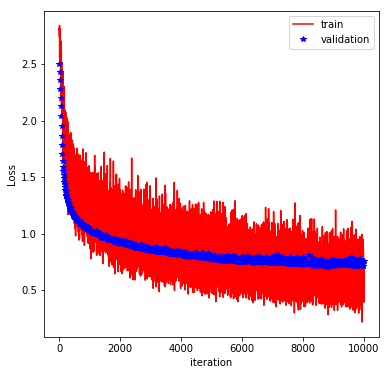

In [13]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

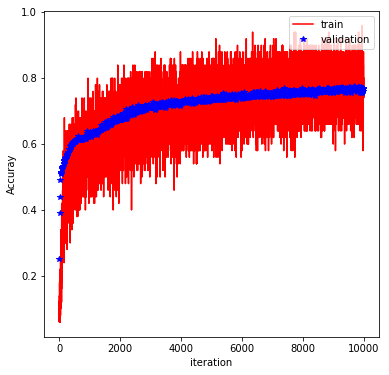

In [14]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [15]:
test_acc = []
test_loss = []
test_pred = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t, x_t_f, x_t_p in get_batches(X_test, y_test, X_test_feats, X_test_p, 157):
        feed = {inputs_: x_t,
                labels_: y_t,
                inputs2_: x_t_f,
                inputs3_: x_t_p,
                keep_prob_: 1}
        
        batch_loss, batch_acc = sess.run([cost, accuracy], feed_dict=feed)
        test_acc.append(batch_acc)
        test_loss.append(batch_loss)
        
        predict=tf.argmax(logits,1)
        best = predict.eval(feed_dict=feed)
        test_pred.append(best)
    
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
    print("Test loss: {:.6f}".format(np.mean(test_loss)))
    
    oof_preds = np.concatenate(test_pred, axis=0)

INFO:tensorflow:Restoring parameters from checkpoints-cnn\har.ckpt
Test accuracy: 0.772611
Test loss: 0.712078


In [16]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

[ 9  2  2 ... 13  2 11]
[ 9  2  2 ... 13 12 11]
Normalized confusion matrix
[[0.7        0.         0.03333333 0.         0.06666667 0.03333333
  0.03333333 0.         0.13333333 0.         0.         0.
  0.         0.        ]
 [0.         0.61616162 0.         0.06060606 0.         0.
  0.02020202 0.         0.         0.         0.         0.3030303
  0.         0.        ]
 [0.         0.         0.98378378 0.         0.         0.
  0.         0.         0.00540541 0.         0.         0.00540541
  0.00540541 0.        ]
 [0.         0.0125523  0.         0.52719665 0.0041841  0.
  0.05857741 0.         0.         0.         0.         0.38912134
  0.         0.0083682 ]
 [0.         0.         0.         0.25       0.         0.
  0.05555556 0.         0.         0.         0.         0.69444444
  0.         0.        ]
 [0.16666667 0.         0.         0.         0.         0.83333333
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.   

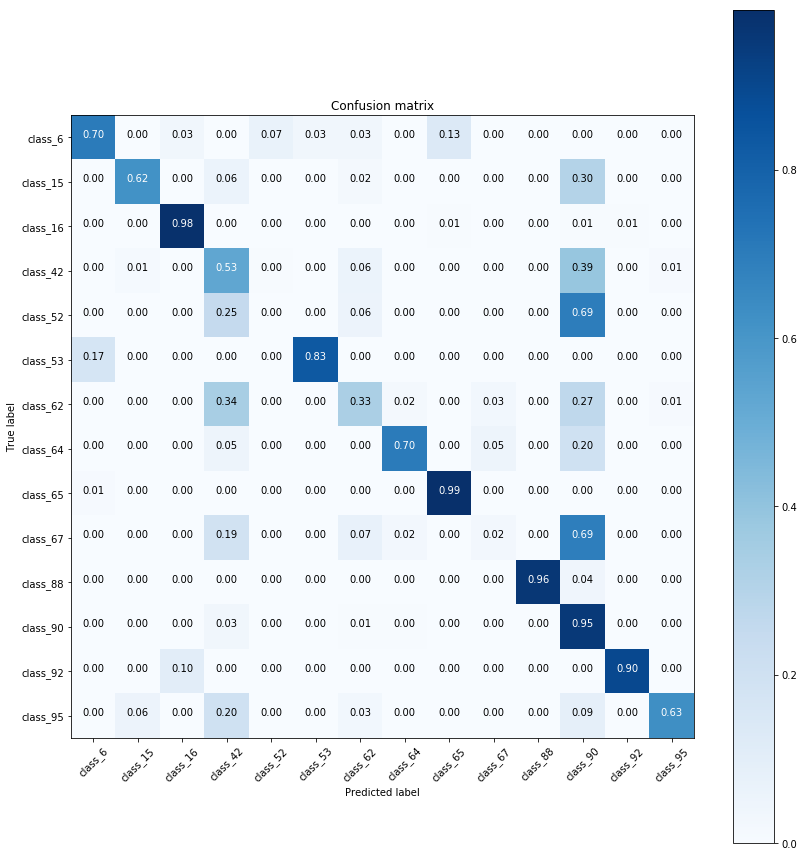

In [17]:
print(np.asarray(labels_test))

print(oof_preds+1)

cnf_matrix = confusion_matrix(np.asarray(labels_test), oof_preds+1)
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')